<a href="https://colab.research.google.com/github/okayteakay/Interpretable-ML/blob/main/GRADCAMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import cv2
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

## GradCAM

In [ ]:
class GradCAM(object):
    def __init__(self, model_dict, verbose=False):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        if 'vgg' in model_type.lower():
            target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            target_layer = find_squeezenet_layer(self.model_arch, layer_name)

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("please specify size of input image in model_dict. e.g. {'input_size':(224, 224)}")
                pass
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('saliency_map size :', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):

        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


## GradCAM++

In [ ]:
class GradCAMpp(GradCAM):
    def __init__(self, model_dict, verbose=False):
        super(GradCAMpp, self).__init__(model_dict, verbose)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze() 
            
        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value'] # dS/dA
        activations = self.activations['value'] # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
                activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit

## Heatmap visualization function

In [ ]:
def heatmap_visualization(mask, img):
  
  heatmap = cv2.applyColorMap(np.uint8(255 * mask.cpu().squeeze()), cv2.COLORMAP_JET)
  heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
  b, g, r = heatmap.split(1)
  heatmap = torch.cat([r, g, b])

  result = heatmap+img.cpu()
  result = result.div(result.max()).squeeze()

  return heatmap, result


## Find Layers from NNs

### Resnet

In [ ]:
def find_resnet_layer(arch, target_layer_name):

  if 'layer' in target_layer_name:
    hierarchy = target_layer_name.split('_')
    layer_num = int(hierarchy[0].lstrip('layer'))
    if layer_num == 1:
      target_layer = arch.layer1
    elif layer_num == 2:
      target_layer = arch.layer2
    elif layer_num == 3:
      target_layer = arch.layer3
    elif layer_num == 4:
      target_layer = arch.layer4
    else:
      raise ValueError('unknown layer : {}'.format(target_layer_name))

    if len(hierarchy) >= 2:
      bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
      target_layer = target_layer[bottleneck_num]

    if len(hierarchy) >= 3:
      target_layer = target_layer._modules[hierarchy[2]]
  
    if len(hierarchy) == 4:
      target_layer = target_layer._modules[hierarchy[3]]

  else:
    target_layer = arch._modules[target_layer_name]

  return target_layer

### Densenet

In [ ]:
def find_densenet_layer(arch, target_layer_name):

  hierarchy = target_layer_name.split('_')
  target_layer = arch._modules[hierarchy[0]]

  if len(hierarchy) >= 2:
      target_layer = target_layer._modules[hierarchy[1]]

  if len(hierarchy) >= 3:
      target_layer = target_layer._modules[hierarchy[2]]

  if len(hierarchy) == 4:
      target_layer = target_layer._modules[hierarchy[3]]

  return target_layer

### VGG

In [ ]:
def find_vgg_layer(arch, target_layer_name):

  hierarchy = target_layer_name.split('_')

  if len(hierarchy) >= 1:
    target_layer = arch.features

  if len(hierarchy) == 2:
    target_layer = target_layer[int(hierarchy[1])]

  return target_layer

### Alexnet 

In [ ]:
def find_alexnet_layer(arch, target_layer_name):

  hierarchy = target_layer_name.split('_')

  if len(hierarchy) >= 1:
    target_layer = arch.features

  if len(hierarchy) == 2:
    target_layer = target_layer[int(hierarchy[1])]

  return target_layer

### Squeezenet

In [ ]:
def find_squeezenet_layer(arch, target_layer_name):

  hierarchy = target_layer_name.split('_')
  target_layer = arch._modules[hierarchy[0]]

  if len(hierarchy) >= 2:
    target_layer = target_layer._modules[hierarchy[1]]

  if len(hierarchy) == 3:
    target_layer = target_layer._modules[hierarchy[2]]

  elif len(hierarchy) == 4:
    target_layer = target_layer._modules[hierarchy[2]+'_'+hierarchy[3]]

  return target_layer

## De-normalize & Normalize

In [ ]:
def denormalize(tensor, mean, std):
  
  if not tensor.ndimension() == 4:
    raise TypeError('tensor should be 4D')

  mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
  std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

  return tensor.mul(std).add(mean)

In [ ]:
def normalize(tensor, mean, std):
  
  if not tensor.ndimension() == 4:
    raise TypeError('tensor should be 4D')

  mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
  std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

  return tensor.sub(mean).div(std)


In [ ]:
class Normalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    return self.do(tensor)

  def do(self, tensor):
    return normalize(tensor, self.mean, self.std)

  def undo(self, tensor):
    return denormalize(tensor, self.mean, self.std)

  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Inference Testing

In [ ]:
img1_path = '/content/kangaroo.jpg'
img1 = PIL.Image.open(img1_path)
img2_path = '/content/biker.jpg'
img2 = PIL.Image.open(img2_path)
img3_path = '/content/child.jpg'
img3 = PIL.Image.open(img3_path)

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_img1 = torch.from_numpy(np.asarray(img1)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img1 = F.upsample(torch_img1, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img1 = normalizer(torch_img1)

torch_img2 = torch.from_numpy(np.asarray(img2)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img2 = F.upsample(torch_img2, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img2 = normalizer(torch_img2)

torch_img3 = torch.from_numpy(np.asarray(img3)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img3 = F.upsample(torch_img3, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img3 = normalizer(torch_img3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval(), alexnet.cuda();

vgg = models.vgg16(pretrained=True)
vgg.eval(), vgg.cuda();

resnet = models.resnet101(pretrained=True)
resnet.eval(), resnet.cuda();

densenet = models.densenet161(pretrained=True)
densenet.eval(), densenet.cuda();

squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.eval(), squeezenet.cuda();


cam_dict = dict()

alexnet_model_dict = dict(type='alexnet', arch=alexnet, layer_name='features_11', input_size=(224, 224))
alexnet_gradcam = GradCAM(alexnet_model_dict, True)
alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

densenet_model_dict = dict(type='densenet', arch=densenet, layer_name='features_norm5', input_size=(224, 224))
densenet_gradcam = GradCAM(densenet_model_dict, True)
densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
squeezenet_gradcam = GradCAM(squeezenet_model_dict, True)
squeezenet_gradcampp = GradCAMpp(squeezenet_model_dict, True)
cam_dict['squeezenet'] = [squeezenet_gradcam, squeezenet_gradcampp]

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


saliency_map size : torch.Size([13, 13])
saliency_map size : torch.Size([13, 13])
saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([13, 13])
saliency_map size : torch.Size([13, 13])


In [ ]:
images1 = []
for gradcam, gradcam_pp in cam_dict.values():
  mask, _ = gradcam(normed_torch_img1)
  heatmap, result = heatmap_visualization(mask, torch_img1)

  mask_pp, _ = gradcam_pp(normed_torch_img1)
  heatmap_pp, result_pp = heatmap_visualization(mask_pp, torch_img1)

  images1.append(torch.stack([torch_img1.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images1 = make_grid(torch.cat(images1, 0), nrow=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
images2 = []
for gradcam, gradcam_pp in cam_dict.values():
  mask, _ = gradcam(normed_torch_img2)
  heatmap, result = heatmap_visualization(mask, torch_img2)

  mask_pp, _ = gradcam_pp(normed_torch_img2)
  heatmap_pp, result_pp = heatmap_visualization(mask_pp, torch_img2)

  images2.append(torch.stack([torch_img2.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images2 = make_grid(torch.cat(images2, 0), nrow=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
images3 = []
for gradcam, gradcam_pp in cam_dict.values():
  mask, _ = gradcam(normed_torch_img3)
  heatmap, result = heatmap_visualization(mask, torch_img3)

  mask_pp, _ = gradcam_pp(normed_torch_img3)
  heatmap_pp, result_pp = heatmap_visualization(mask_pp, torch_img3)

  images3.append(torch.stack([torch_img3.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images3 = make_grid(torch.cat(images3, 0), nrow=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

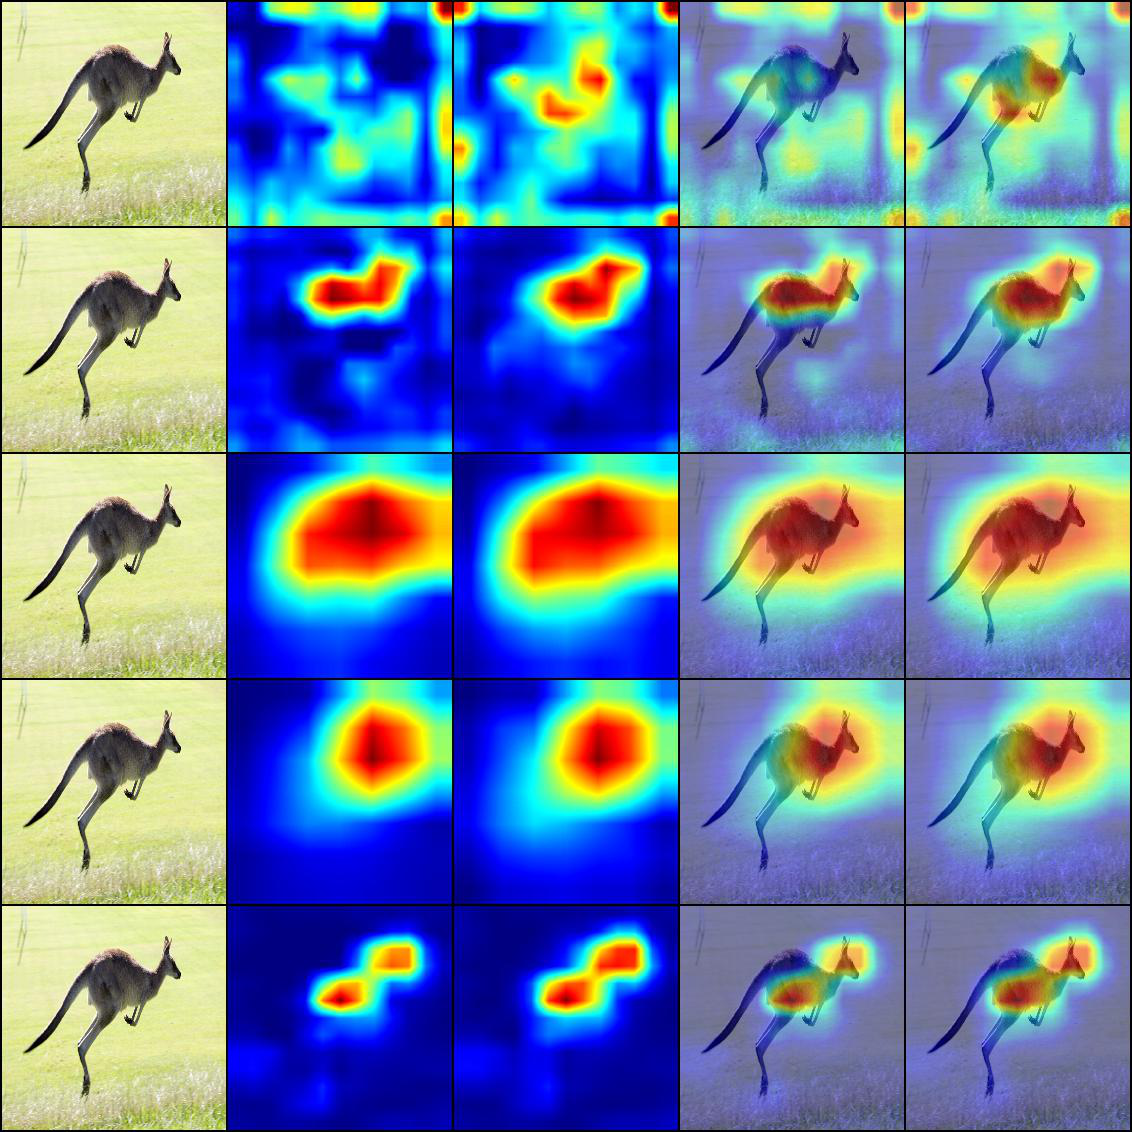

In [ ]:
output1 = 'kangaroo.jpg'
output_path1 = os.path.join(output_dir, output1)
save_image(images1, output_path1)
PIL.Image.open(output_path1)

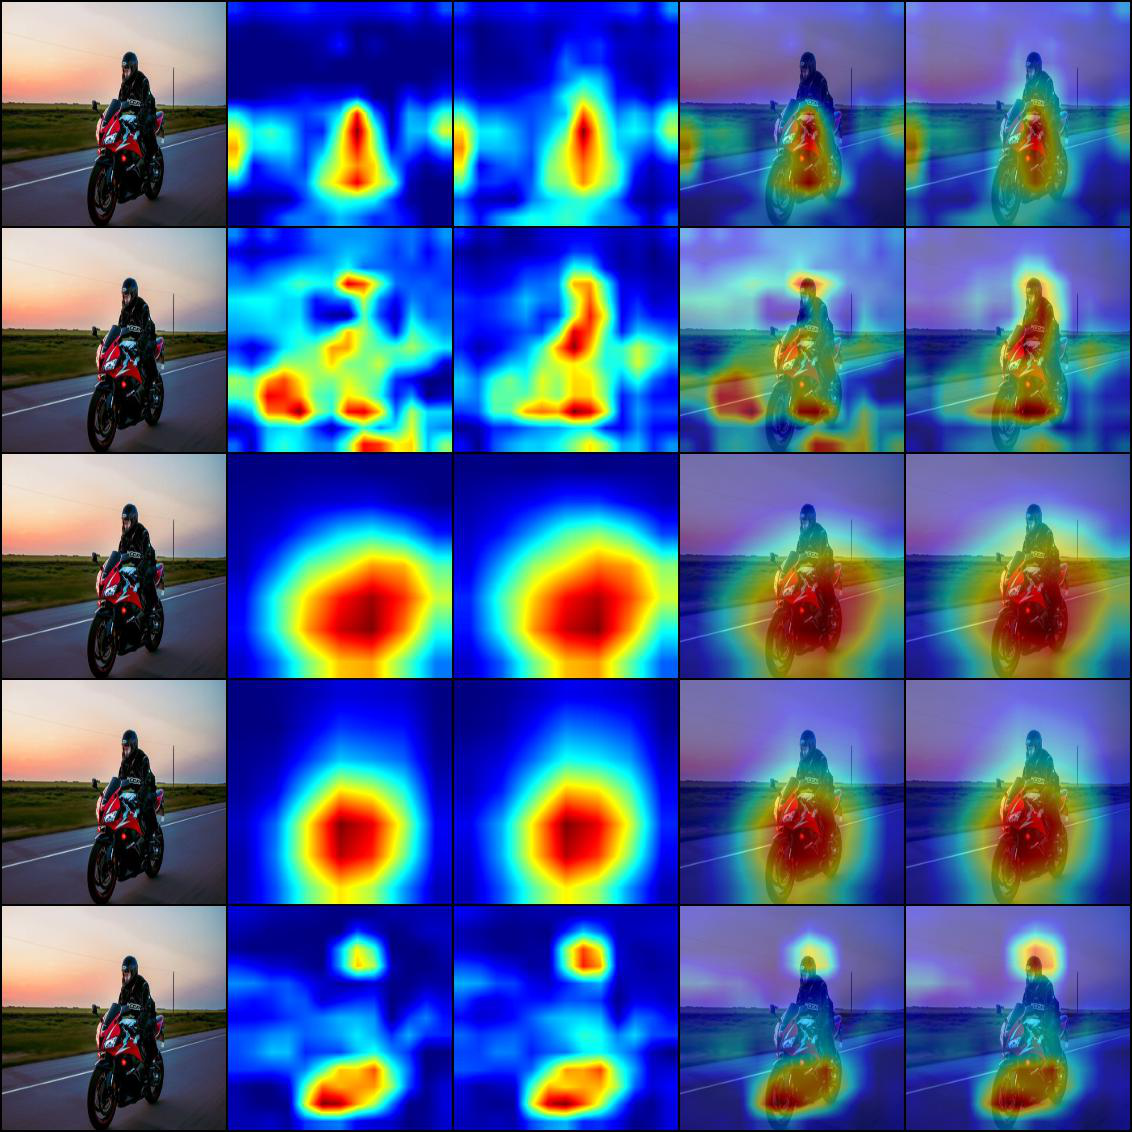

In [ ]:
output2 = 'biker.jpg'
output_path2 = os.path.join(output_dir, output2)
save_image(images2, output_path2)
PIL.Image.open(output_path2)

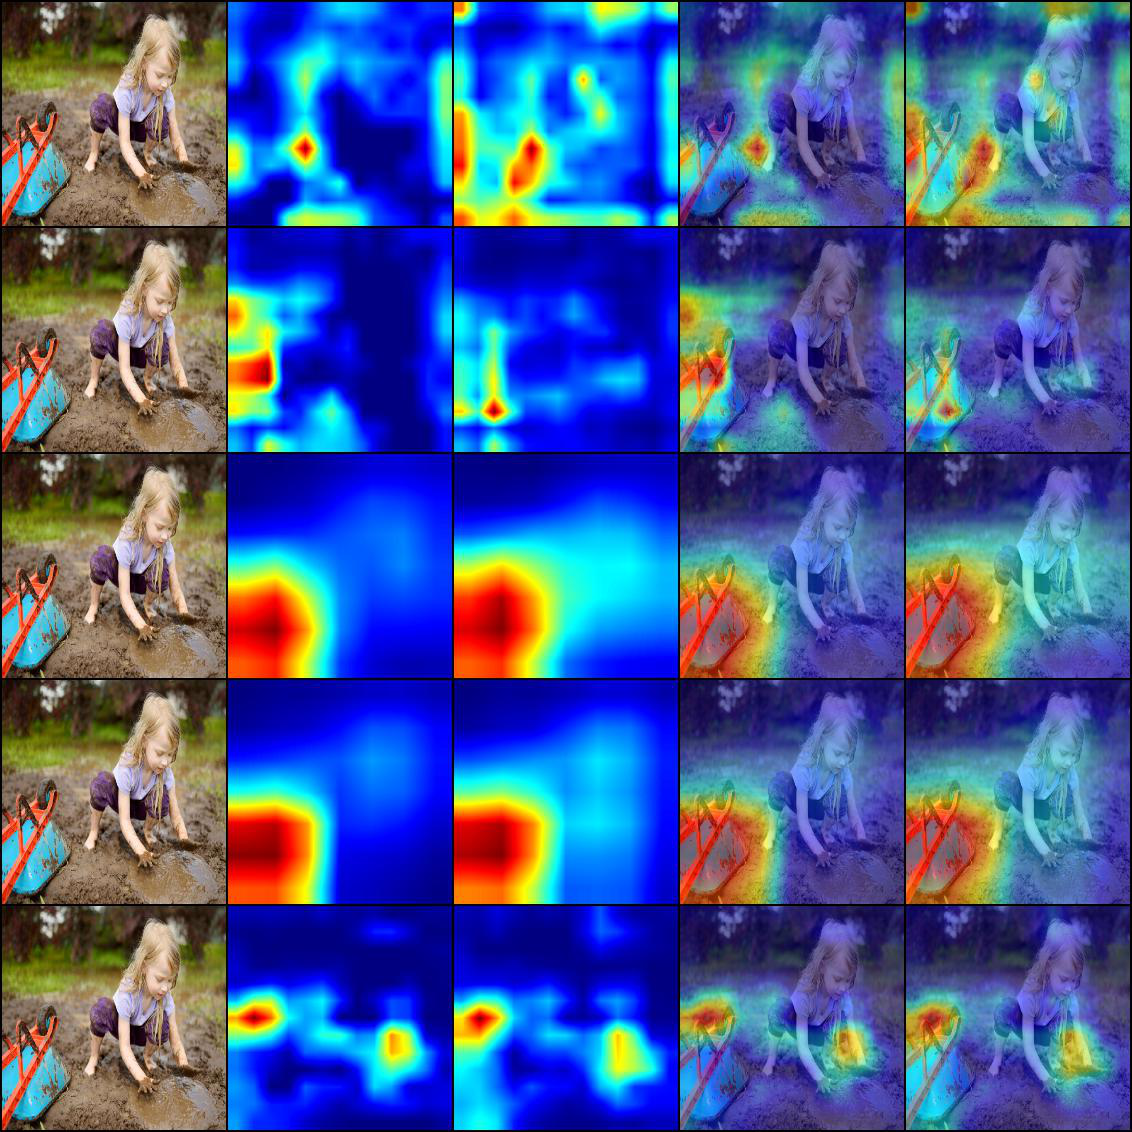

In [ ]:
output3 = 'child.jpg'
output_path3 = os.path.join(output_dir, output3)
save_image(images3, output_path3)
PIL.Image.open(output_path3)